In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pickle
import joblib
from joblib import dump, load
from keras import models

model = models.load_model("/content/drive/MyDrive/BTP_MedicalImages/Spec_segmentation_WithNetGenLabelImages_3.h5")
model.load_weights("/content/drive/MyDrive/BTP_MedicalImages/best_weights_Spec_segmentation_WithNetGenLabelImages_3.hdf5")
print('Model Loaded successfully')

Model Loaded successfully


number of new images in list:  (56,)
2/2 [==============================] - 10s 4s/step


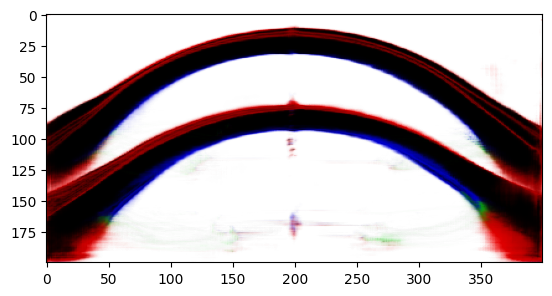

In [ ]:
import glob
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
imgpath = '/content/drive/MyDrive/BTP_MedicalImages/images 1/Dataset_Part/T000'
OCT_list = sorted(glob.glob(imgpath+'*.jpg'))
print("number of new images in list: ",np.shape(OCT_list))

for i in range(len(OCT_list)):
  temp= (OCT_list[i].split('Dataset_Part'+'/')[1]).split('.')[0]
  img =  np.asarray(Image.open('/content/drive/MyDrive/BTP_MedicalImages/images 1/Dataset_Part'+'/'+temp+'.jpg').resize((400,200)).
                    convert('L'),dtype=np.uint8)
  np.save('/content/drive/MyDrive/BTP_MedicalImages/images 1/Dataset_Part'+'/'+temp,img)


OCT_list = sorted(glob.glob(imgpath+'*.npy'))
OCT_img = []

# New Images List
for i in range(len(OCT_list)):
  temp_name = (OCT_list[i].split( 'Dataset_Part'+'/')[1]).split('.')[0]+'.npy'
  img=np.load(OCT_list[i]) #read the image
  img = np.asarray(img, dtype=np.float32)
  img=(img-np.min(img))/(np.max(img)-np.min(img)) #normalize the intensities to bring between 0 and 1
  OCT_img.append(img)

OCT_img = np.asarray(OCT_img)
test_imgs  =OCT_img[0:56]
test_images = np.expand_dims(test_imgs,axis=3)
test_preds = model.predict(test_images) #obtain predictions for glaucoma
for i in range(len(test_preds)):
  plt.imshow(test_preds[i])

In [ ]:
from itertools import product
def process_label(label_file):
        """
        This fucntion takes label files with layers marked from 1 to 8, not 0 to 7
        """
        colors = np.zeros((9,3),dtype=np.uint8)

        #### colors for each label edit accordingly
        colors[0] = [0, 0, 0]
        colors[1] = [255,0,0]
        colors[2] = [0,255,0]
        colors[3] = [0,0,255]
        colors[4] = [255,255,0]
        colors[5] = [255,0,255]
        colors[6] = [0, 255, 255]
        colors[7] = [255, 153, 51]
        colors[8] = [255, 255, 255]

        H = np.shape(label_file)[0]
        W = np.shape(label_file)[1]

        img = np.zeros((H,W,3),dtype=np.uint8)
        for i,j in product(range(H),range(W)):
            img[i, j] = colors[label_file[i,j]-1]

        return np.asarray(img)

In [ ]:
from ipywidgets import interact
img_data=test_images
label_data=test_preds

@interact(x=(0,len(img_data)-1,1)) #Function responsible for creating the slider. Usage format @interact(start,end,step size)
def h(x=0): #Starting number of the slider
    f = plt.figure(figsize=(12,6))
    plt.rcParams.update({'font.size': 12})
    f.subplots_adjust(left = 0.02,right = 0.75,wspace = 0.01,hspace = 0.3)

    f.add_subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img_data[x,:,:,0], cmap='gray')
    plt.title("Test image")

    f.add_subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    color_label= process_label(np.argmax(label_data[x], axis=2)+1)
    plt.imshow(color_label)
    plt.title("Network prediction")

    f.add_subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    color_label= process_label(np.argmax(label_data[x], axis=2)+1)
    segmented_image = Image.fromarray(color_label)
    width, height = segmented_image.size
    # Crop the image
    left = 325
    top = 100
    right = 375
    bottom = 190
    cropped_image = segmented_image.crop((left, top, right, bottom))
    # Display the cropped image
    plt_array = np.array(cropped_image)
    plt.imshow(plt_array)
    plt.title("Scleral Spur Localisation")
    # plt.savefig('./'+str(x) +'.png',dpi=200)
    plt.show()


interactive(children=(IntSlider(value=0, description='x', max=55), Output()), _dom_classes=('widget-interact',…

In [ ]:
import cv2
@interact(x=(0,len(img_data)-1,1)) #Function responsible for creating the slider. Usage format @interact(start,end,step size)
def h(x=0): #Starting number of the slider
    color_label= process_label(np.argmax(label_data[x], axis=2)+1)
    lower_color = np.array([0, 255, 0])
    upper_color = np.array([0, 255, 0])
    mask = cv2.inRange(color_label,lower_color,upper_color)
    # Find the contours of the detected pixels
    contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Get the coordinates of the corner points of each contour
    corner_points = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        top_left = (x, y)
        top_right = (x + w, y)
        bottom_left = (x, y + h)
        bottom_right = (x + w, y + h)
        corner_points.append([top_left, top_right, bottom_left, bottom_right])
    # Print the corner points
    print(corner_points)


interactive(children=(IntSlider(value=0, description='x', max=55), Output()), _dom_classes=('widget-interact',…

In [ ]:
from google.colab.patches import cv2_imshow
@interact(x=(0,len(img_data)-1,1)) #Function responsible for creating the slider. Usage format @interact(start,end,step size)
def h(x=0): #Starting number of the slider
  color_label= process_label(np.argmax(label_data[x], axis=2)+1)
  lower_color = np.array([0, 255, 0])
  upper_color = np.array([0, 255, 0])
  mask = cv2.inRange(color_label,lower_color,upper_color)
  # Find the contours of the detected pixels
  contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  # Get the coordinates of the corner points of each contour
  corner_points = []
  for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    top_left = (x, y)
    top_right = (x + w, y)
    bottom_left = (x, y + h)
    bottom_right = (x + w, y + h)
    corner_points.append([top_left, top_right, bottom_left, bottom_right])
  # Scleral-Spur Coordinates
  right_center = corner_points[0][3]
  left_center = corner_points[0][2]
  radius = 1
  # Draw the circle on the image
  cv2.circle(color_label, right_center, radius, (0,165,255), 2)
  cv2.circle(color_label, left_center, radius, (0,165,255), 2)
  # Display the image with the circle
  cv2_imshow(color_label)
  cv2.waitKey(0)
  cv2.destroyAllWindows()



interactive(children=(IntSlider(value=0, description='x', max=55), Output()), _dom_classes=('widget-interact',…

In [ ]:
enlarged_set = []
for i in range(len(label_data)):
  color_label= process_label(np.argmax(label_data[i], axis=2)+1)
  segmented_image = Image.fromarray(color_label)
  width, height = segmented_image.size
  # Crop the image
  left = 300
  top = 100
  right = 375
  bottom = 190
  cropped_image = segmented_image.crop((left, top, right, bottom))
  # Display the cropped image
  enlarged_array = np.array(cropped_image)
  enlarged_set.append(enlarged_array)

In [ ]:
@interact(x=(0,len(img_data)-1,1)) #Function responsible for creating the slider. Usage format @interact(start,end,step size)
def h(x=0): #Starting number of the slider
  color_label = enlarged_set[x]
  lower_color = np.array([0, 255, 0])
  upper_color = np.array([0, 255, 0])
  mask = cv2.inRange(color_label,lower_color,upper_color)
  # Find the contours of the detected pixels
  contours, hierarchy = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  # Get the coordinates of the corner points of each contour
  corner_points = []
  for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    top_left = (x, y)
    top_right = (x + w, y)
    bottom_left = (x, y + h)
    bottom_right = (x + w, y + h)
    corner_points.append([top_left, top_right, bottom_left, bottom_right])
  print(corner_points)
  # Scleral-Spur Coordinates
  center = corner_points[0][3]
  radius = 5
  # Draw the circle on the image
  cv2.circle(color_label, center, radius, (255, 255, 255), 2)
  # Display the image with the circle
  cv2_imshow(color_label)

interactive(children=(IntSlider(value=0, description='x', max=55), Output()), _dom_classes=('widget-interact',…

In [ ]:
from PIL import Image
@interact(x=(0,len(img_data)-1,1)) #Function responsible for creating the slider. Usage format @interact(start,end,step size)
def h(x=0): #Starting number of the slider
  # Load the image
  segmented_image = process_label(np.argmax(label_data[x], axis=2)+1)
  img = Image.fromarray(segmented_image)
  # Get the width and height of the image
  width, height = img.size
  # Iterate over each pixel in the image, starting from the right-most column
  for x in range(width-1, -1, -1):
      for y in range(height):
          # Get the color of the pixel at (x, y)
          r, g, b = img.getpixel((x, y))
          # Check if the pixel is pure green
          if r == 0 and g == 255 and b == 0:
              # Found the right-most pure green pixel
              print("Most-right pixel of pure green color: ({}, {})".format(x, y))
              right_SS_Center = [x,y]
              break
      else:
          continue
      break
  # Iterate over each pixel in the image, starting from the left-most column
  for x in range(width):
    for y in range(height):
        # Get the color of the pixel at (x, y)
        r, g, b = img.getpixel((x, y))
        # Check if the pixel is pure green
        if r == 0 and g == 255 and b == 0:
            # Found the left-most pure green pixel
            print("Most-left pixel of pure green color: ({}, {})".format(x, y))
            left_SS_Center = [x,y]
            break
    else:
        continue
    break
  right_center = right_SS_Center
  left_center = left_SS_Center
  radius = 1
  # Draw the circle on the image
  cv2.circle(segmented_image, right_center, radius, (255, 255, 255), 2)
  cv2.circle(segmented_image, left_center, radius, (255, 255, 255), 2)
  # Display the image with the circle
  cv2_imshow(segmented_image)

interactive(children=(IntSlider(value=0, description='x', max=55), Output()), _dom_classes=('widget-interact',…